This notebook implements the autoregressive-flow model. Here, we were capable to learn multi-modal distributions but no correlations between the components. This is due to the fact that the inputs of each RNN depend on the previous parameters and not the previous component. 

See 'Learning_Isin.ipynb' for the well-finished project (or Real Recurrent Model at the end of the notebook, not so clean). 

# Imports

In [1]:
!pip install jax
!pip install jaxlib

!pip install --upgrade pip # To support manylinux2010 wheels.
!pip install --upgrade jax jaxlib # CPU-only
!pip install flax
!pip install --upgrade git+https://github.com/google/flax.git

!pip install distrax
!pip install --upgrade distrax

!pip install git+https://github.com/deepmind/dm-haiku
!pip install --upgrade haiku

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 2.7 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 MB 12.2 MB/s eta 0:00:00
  Created wheel for jax: filename=jax-0.3.15-py3-none-any.whl size=1201920 sha256=e5c2bcb2305108f2e89aea7e364fe4d647abfe35306a412caad507fdad29c0c7
  Stored in directory: /root/.cache/pip/wheels/7b/36/dc/9

In [2]:
import numpy as np 
import matplotlib.pyplot as plt

import jax 
import jax.numpy as jnp
import jax.random as rnd
key = rnd.PRNGKey(12)

from jax import jit, vmap, grad
import flax.linen as nn
from jax.config import config; config.update("jax_enable_x64", True)
from jax.core import NamedShape
from jax.tree_util import tree_map


from functools import partial

try:
    from tqdm.auto import tqdm  # progressbar
except ImportError:
    tqdm = lambda x: x

from typing import Any, Callable, Sequence

import distrax
#from tensorflow_probability.substrates import jax as tfp
#tfd = tfp.distributions
from distrax._src.bijectors.scalar_affine import ScalarAffine
from distrax._src.bijectors.shift import Shift

import optax

import haiku as hk

# Learning easily (1D no NN)

## Distribution

In [ ]:
def normal(x,mu=0,sigma=1):
  return jnp.exp(-(x-mu)**2/2/sigma**2)/jnp.sqrt(2*jnp.pi)/sigma


class Distribution:
  '''
  Creates a distribution which is an addition of two gaussians.
  The proportionality between the two is given by prop. 

  x ~ prop*N(mu1,sigma1) + (1-prop)*N(mu2,sigma2). 
  '''

  def __init__(self,mu1,mu2,sigma1,sigma2,prop=0.5):
    assert prop <= 1 and prop >= 0
    self.mu1 = mu1
    self.mu2 = mu2
    self.sigma1 = sigma1
    self.sigma2 = sigma2

    self.prop=prop

  def p(self,x):
    '''
    probability of a sample x
    '''
    return self.prop*normal(x,self.mu1,self.sigma1) + (1-self.prop)*normal(x,self.mu2,self.sigma2)

  @partial(jit, static_argnums=0)
  def log_prob(self,x):
    '''
    unnormalized log probability of a sample
    does not need to be a nomralized probability
    '''
    return jnp.log( self.prop*jnp.exp(-(x-self.mu1)**2/2/self.sigma1**2)/self.sigma1 + (1-self.prop)*jnp.exp(-(x-self.mu2)**2/2/self.sigma2**2)/self.sigma2 )[:,0]
  
  def sample(self,key,T=1,Ns=500):
    '''
    Draw samples according to p (normally we don't have it, here we are only testing)
    only works if p is normalized
    '''
    key1, key2 = rnd.split(key)

    eta = rnd.uniform(key1, shape=(T,Ns))
    mask = jnp.array((eta<self.prop), dtype=int)

    z = rnd.normal(key2, shape=(T,Ns))

    return mask * (z*self.sigma1 + self.mu1) + (1-mask)*(z*self.sigma2 + self.mu2)


## Learn

In [ ]:
def plot(q,p, key=rnd.PRNGKey(12), loss=None, Ns=1000, name=None):
  key1, key2 = rnd.split(key)
  x, logq = q._sample_n_and_log_prob(key1, Ns)


  idx = jnp.argsort(x)


  plt.figure(figsize=(16,4))


  plt.subplot(1,3,2)
  plt.title('Sampling q_θ')
  hst = plt.hist(x, label='q_θ', bins=20)

  qmax = jnp.max(hst[0])
  probs_p = jnp.exp( p.log_prob(x[idx]) )

  C = qmax/jnp.max(probs_p)
  A = jnp.max(probs_p)/np.exp( jnp.max(logq) )

  plt.plot(x[idx], C*probs_p ,label='p')
  plt.legend()

  plt.subplot(1,3,3)
  plt.title('Probability')
  plt.plot(x[idx], A*jnp.exp( logq[idx] ), label='q_θ')
  plt.plot(x[idx], jnp.exp( p.log_prob(x[idx]) ),label='p')
  plt.legend()

  if loss is None: 
    plt.show()
    return

  plt.subplot(1,3,1)
  plt.title('Evolution of the loss')
  plt.plot(loss)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')

  if name is None: 
    plt.show()
    return 

  plt.savefig(name, dpi=200, bbox_inches='tight')
  plt.show()
  return


def q_theta(params):
  bij = distrax.Chain([ distrax.Inverse( distrax.Tanh() ), 
                       distrax.RationalQuadraticSpline(params, -1.0, 1.0), 
                       ])
  return distrax.Transformed( distrax.Uniform(-1,1), bij )


################################################################################
@jit
def log_q(params, x):
  '''
  Computes the log probability of the sample x in the parametrized distribution
  params : parameters of the distribution q_theta
  x : single sample for which we evaluate ()

  Returns : log(q_theta(x)) ()
  '''
  bij = distrax.Chain([ distrax.Inverse( distrax.Tanh() ), 
                       distrax.RationalQuadraticSpline(params, -1.0, 1.0), 
                       ])
  q =  distrax.Transformed( distrax.Uniform(-1,1), bij )

  return q.log_prob(x)

def loss_and_grad(key, params, p, Ns):
  '''
  Computes the loss and its gradient
  key : random key to use
  params : parameters of the distribution q_theta
  p : distribution to learn
  Ns : number of samples
  
  Returns : loss () and gradient of the loss (params.shape)
  '''
  # Construct the parametrized distribution
  bij = distrax.Chain([ distrax.Inverse( distrax.Tanh() ), 
                       distrax.RationalQuadraticSpline(params, -1.0, 1.0), 
                       ])
  q =  distrax.Transformed( distrax.Uniform(-1,1), bij )

  # sample from q
  data = q._sample_n(key, Ns)

  # get the values to average
  logq, d_logq = vmap( jax.value_and_grad(log_q, 0), (None,0), -1 )(params, data)

  logp = p.log_prob(data)

  # compute L and grad_L as expectation value over x~q
  L = jnp.mean( logq - logp )
  grad_L = jnp.mean( d_logq*(logq - logp), axis = -1 )

  return L, grad_L

### Tests

[8.84261451e-01 8.73094297e-01 3.36202489e-01 2.12963283e-01
 1.27898847e-01 2.92199620e-01 3.07833344e-01 7.07058081e-01
 5.67816733e-01 3.19321156e-01 1.21034329e-01 6.54182289e-01
 7.69759385e-01 6.70143110e-01 5.62226765e-01 9.27920411e-01
 6.26132204e-01 8.69864313e-01 3.55446259e-01 7.21637887e-01
 6.12749660e-01 7.56232848e-01 2.05246141e-01 4.41909885e-04
 7.86708633e-01 3.97205658e-02 5.09226936e-02 6.25560504e-02
 1.25045793e-01 1.68634276e-01 9.08546574e-01]
New implementation 	 -0.6537771120532068 [ 8.79916805e-02  6.12084403e-02 -2.51379636e-02  4.45252000e-02
  7.08388029e-02  4.24257172e-02  5.00701877e-02 -7.98106413e-02
  6.49364542e-02 -3.17047878e-01 -2.63196985e-01  1.01363053e-02
  9.54947056e-02 -2.35605382e-03 -2.52292196e-02 -9.11355155e-02
 -7.93093781e-02  5.56232824e-02 -5.05631384e-02  3.50535997e-01
 -3.56398984e-02  4.32001054e-02 -2.35390553e-04 -1.13544747e-03
 -6.38262958e-03 -1.12950758e-02  1.18567305e-04 -1.72061782e-02
  7.99289131e-03  1.05197203e-

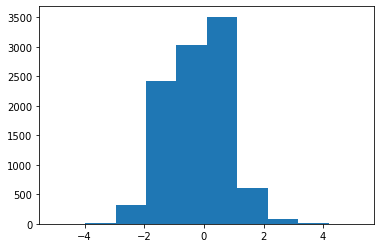

In [ ]:
# Test implementation, dimensions and range

mu1=-1
mu2=1
sigma1=0.5
sigma2=0.5
prop = 0.3
p = Distribution(mu1,mu2,sigma1,sigma2,prop=prop)

nbins = 10
key = rnd.PRNGKey(2)
params_test = rnd.uniform(key, (3*nbins+1,))
key, _ = rnd.split(key, 2)

plt.hist( q_theta(params_test)._sample_n(key, 10000) )
print(params_test)
key1, key2 = rnd.split(key, 2)


l, g = loss_and_grad(key1, params_test,p, Ns=15)

print(l, g)

In [ ]:
# Testing the grad with finite differences

key = rnd.PRNGKey(10)

mu1=-1
mu2=1
sigma1=0.5
sigma2=0.5
prop = 0.3
p = Distribution(mu1,mu2,sigma1,sigma2,prop=prop)

nbins = 5
key = rnd.PRNGKey(12)
params = rnd.uniform(key, (3*nbins+1,))
key, _ = rnd.split(key, 2)

Ns = 1e7
step = 1e-13

_, real_g = loss_and_grad(key, params, p, Ns)

for idx in range(3*nbins+1):
  # select component to derivate
  mask = np.zeros_like(params)
  mask[idx] = 1

  # finite differences
  plus_l, _ = loss_and_grad(key, params + mask*step, p, Ns)
  minus_l, _ = loss_and_grad(key, params - mask*step, p, Ns)
  finite_diff = (plus_l - minus_l)/step/2

  # compare
  print(idx, real_g[idx], finite_diff, '\n')



0 -0.24496520190930365 -0.238073449843057 

1 0.5656834720314002 0.5642708522657358 

2 0.09862631636053251 0.09818534874028728 

3 -0.051582534729380965 -0.05842548667089886 

4 -0.36776205175324833 -0.3617939281497229 

5 0.3025914810623928 0.29726221484338566 

6 -0.38393582305255325 -0.37740643943351415 

7 -0.2503512026580946 -0.2531308496145357 

8 -0.0504891427502616 -0.05703770789011742 

9 0.38218468739851663 0.38719027983802334 

10 -0.012853948944292065 -0.012906342661267445 

11 0.017581845193805606 0.017555401576885288 

12 0.019289697020376573 0.019290125052862095 

13 0.022726276399797143 0.022620794126737565 

14 0.0027803921362794296 0.0028449465006019636 

15 -0.0055454761851123375 -0.00548172618408671 



### Optimization

  0%|          | 0/5000 [00:00<?, ?it/s]

5000 Loss =  -0.7724700152954053
5200 Loss =  -0.7750402982661608
5400 Loss =  -0.7695910944179394
5600 Loss =  -0.76849343063457
5800 Loss =  -0.7733782049745077
6000 Loss =  -0.7789813353099515
6200 Loss =  -0.7691506135091416
6400 Loss =  -0.7712941155976476
6600 Loss =  -0.7760612274850665
6800 Loss =  -0.7817960770090376
7000 Loss =  -0.7913637174673239
7200 Loss =  -0.77992905852921
7400 Loss =  -0.7813748298821529
7600 Loss =  -0.7927505022988329
7800 Loss =  -0.7912451429913214
8000 Loss =  -0.7960858011174802
8200 Loss =  -0.7901254252203815
8400 Loss =  -0.7768942168417422
8600 Loss =  -0.7882004550848185
8800 Loss =  -0.8042372515473414
9000 Loss =  -0.78923532039304
9200 Loss =  -0.788934552775888
9400 Loss =  -0.7917098994806395
9600 Loss =  -0.8026142585358242
9800 Loss =  -0.8000214694739566


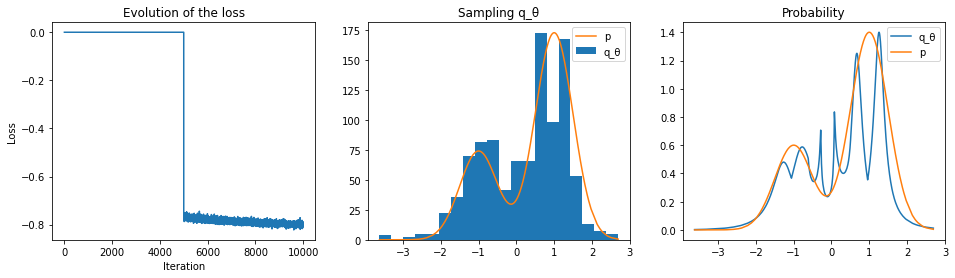

In [ ]:
nsteps = 10000
lr = 1e-3

mu1=-1
mu2=1
sigma1=0.5
sigma2=0.5
prop = 0.3
p = Distribution(mu1,mu2,sigma1,sigma2,prop=prop)

nbins = 7
#key = rnd.PRNGKey(12)
#params = rnd.uniform(key, (3*nbins+1,))
#key, _ = rnd.split(key, 2)

tx = optax.sgd(learning_rate=lr)
opt_state = tx.init(params)

Ns = 10000
L = np.zeros(nsteps)
for i in tqdm(range(5000, nsteps)):
  L[i], g = loss_and_grad(key, params, p, Ns)

  key, _ = rnd.split(key, 2)

  if jnp.abs(L[i]) == np.infty or jnp.isnan(L[i]):
    print(g)
    break

  updates, opt_state = tx.update(g, opt_state)
  params = optax.apply_updates(params, updates)

  if i % 200 == 0:
    print(i, 'Loss = ', L[i])


plot(q_theta(params), p, loss=L, name='1D_distribution_7bins.png')


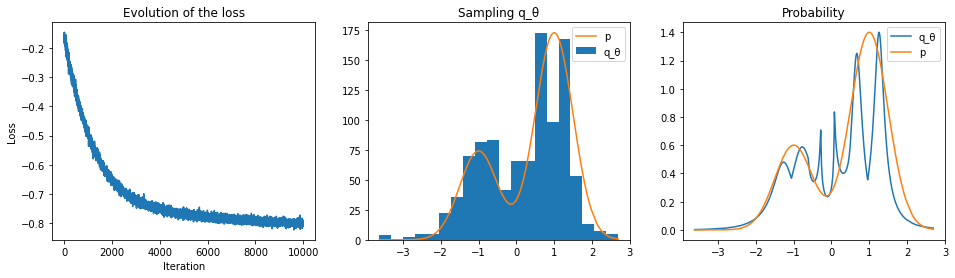

In [ ]:
plot(q_theta(params), p, loss=L, name='1D_distribution_7bins.png')


In [ ]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt

'''
# save to csv file
savetxt(f'/content/trained_7bins_L.csv', L, delimiter=',')
savetxt(f'/content/trained_7bins_p.csv', params, delimiter=',')



g_test = np.loadtxt(f'/content/trained_20bins_p.csv', dtype='float', comments='#', delimiter=',')#, converters=None, skiprows=0, usecols=None, unpack=False, ndmin=0)
L_test = np.loadtxt(f'/content/trained_20bins_L.csv', dtype='float', comments='#', delimiter=',')#, converters=None, skiprows=0, usecols=None, unpack=False, ndmin=0)
'''


# Multi dimensional distributions

### Uncorrelated

In [ ]:
class UncorrelatedBiDimensionalDistribution:
  '''
  Creates a distribution which is an addition of two gaussians.
  The proportionality between the two is given by prop. 
  '''

  def __init__(self,mus,sigmas,coeffs):
    assert len(mus) == len(sigmas) & len(mus) == len(coeffs)
    self.mus = mus
    self.sigmas = sigmas

    self.coeffs=coeffs

  @partial(jit, static_argnums=0)
  def log_prob(self,x):
    '''
    unnormalized log probability of a sample
    does not need to be a nomralized probability
    x : samples (Ns, dimension=len(mus))

    Returns : log_p of the samples (Ns,)
    '''
    p = 0
    for i in range(len(self.mus)):
      p += self.coeffs[i]*jnp.exp(-(x-self.mus[i])**2/2/self.sigmas[i]) / self.sigmas[i]
    
    lp = jnp.sum( jnp.log( p ), axis=-1 )
    return lp



()


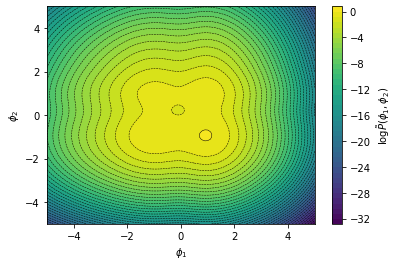

In [ ]:
mus = np.array([[1,1], [1,-1], [-1,1], [-1,-1]])
sigmas = np.array([0.3,1,0.5,0.5])
coeffs = np.array([0.1, 0.4, 0.3, 0.2])
distr = UncorrelatedBiDimensionalDistribution(mus, sigmas, coeffs)



# Verify gaussian shape
x = np.linspace(-5, 5, 101)



p = np.zeros( (101,101) )
for k in range(101):
    for j in range(101):
        p[k,j] = distr.log_p( np.array([x[k],x[j]]) )


fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.contourf(x, x, p, levels=50)
ax.contour(x, x, p, levels=50, colors='black', linewidths=.5)

#im = ax.scatter(phi1, phi2,c=p)
cbar = plt.colorbar(im)
cbar.set_label(r'$\log \tilde{P}(\phi_1, \phi_2)$')
ax.set_xlabel('$\phi_1$')
ax.set_ylabel('$\phi_2$')
plt.show()




In [ ]:

nbins = 4
key = rnd.PRNGKey(2)

test_model = Model(key, hidden_size=10, number_layers=2, mlp_layers=[3,5,3,3*nbins+1], p=distr)

l, g = test_model.loss_and_grad(key, test_model.params, 10000)
key, _ = rnd.split(key, 2)


(10000,)


### Correlated

In [ ]:
class CorrelatedBiDimensionalDistribution:
  '''
  Creates a distribution which is an addition of two gaussians.
  The proportionality between the two is given by prop. 
  '''

  def __init__(self,mus,Sigmas,coeffs):
    self.mus = mus

    # inverse of covariance matrix
    self.C = []
    self.norms = []
    for i in range(len(mus)):
      self.C.append( np.linalg.inv(Sigmas[i]) )
      self.norms.append( np.linalg.norm(self.C[i]) )

    self.coeffs=coeffs

  @partial(jit, static_argnums=0)
  def log_prob(self,data):
    '''
    unnormalized log probability of a sample
    does not need to be a nomralized probability
    data : samples (Ns, dimension=len(mus))

    Returns : log_p of the samples (Ns,)
    '''
    Ns = data.shape[0]

    p = np.zeros( (Ns,) )
    for i in range(len(self.mus)):

      arg = jnp.einsum('...j,jk,...k', (data-self.mus[i]), self.C[i], (data-self.mus[i]) )
      #print( (self.coeffs[i]*np.exp(-arg/2) /np.sqrt(self.norms[i])).shape )
      p += self.coeffs[i]*jnp.exp(-arg/2) /jnp.sqrt(self.norms[i])
    
    lp = jnp.log( p )
    return lp



In [ ]:
np.linalg.eigvals( np.array([[2,-1.2],[-1.2,1]]) )

array([2.8, 0.2])

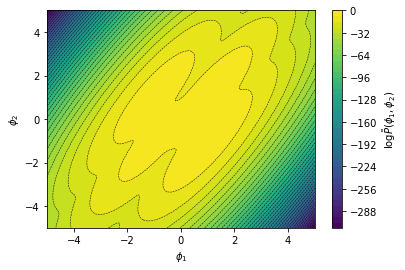

In [ ]:
#mus = [np.array([-1,-1]).T, np.array([1,1]).T]
#sigmas = [np.array([[0.5,0.15],[0.3,0.25]]), np.array([[0.5,0.3],[0.15,0.25]])]
#coeffs = np.array([0.1, 0.3])

mus = [np.array([-1,-1]).T, 
       np.array([-1,1]).T, 
       np.array([1,1]).T, 
       np.array([1,-1]).T
       ]
sigmas = [np.array([[0.5,0.3],[0.3,0.25]]), 
          np.array([[0.5,0.3],[0.3,0.25]]), 
          np.array([[0.5,0.3],[0.3,0.25]]), 
          np.array([[0.5,0.3],[0.3,0.25]])
          ]
coeffs = [0.05, 0.4, 0.4, 0.15]
distr = CorrelatedBiDimensionalDistribution(mus, sigmas, coeffs)



# Verify gaussian shape
x = np.linspace(-5, 5, 101)


p = np.zeros( (101,101) )
for k in range(101):
    for j in range(101):
        p[k,j] = distr.log_prob( np.array([[x[k],x[j]]]) )


fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.contourf(x, x, p, levels=50)
ax.contour(x, x, p, levels=50, colors='black', linewidths=.5)


cbar = plt.colorbar(im)
cbar.set_label(r'$\log \tilde{P}(\phi_1, \phi_2)$')
ax.set_xlabel('$\phi_1$')
ax.set_ylabel('$\phi_2$')
plt.show()




In [ ]:
mus = [np.tile([-1,-1], (10000,1)), np.tile([1,1], (10000,1))]

sigmas = [np.array([[0.5,0.15],[0.3,0.25]]), np.array([[0.5,0.3],[0.15,0.25]])]
coeffs = [0.1, 0.3]
distr = CorrelatedBiDimensionalDistribution(mus, sigmas, coeffs)


nbins = 4
key = rnd.PRNGKey(2)

test_model = Model(key, hidden_size=10, number_layers=2, mlp_layers=[3,5,3,3*nbins+1], p=distr)

l, g = test_model.loss_and_grad(key, test_model.params, 10000)
key, _ = rnd.split(key, 2)


### Ising

In [ ]:
def generate_H(N, beta, h, dim=1):
  '''
  Generates the external field matrix H
  
  N : number of particles
  beta : inverse temperature of the system
  h : amplitude of the field
  dim : numer of dimensions (default 1)

  returns : H matrix (N,)
  '''
  assert dim==1 or dim==2 or dim==3

  return beta*h*np.ones( N**dim )

def generate_NN(N, beta, jnn, dim=1, pbc=True):
  '''
  Generates the interaction matrices (mulriplied by beta) for the second neighbours model

  N : number of particles
  beta : inverse temperature of the system
  jnn : amplitude of the first neighbour interaction
  dim : numer of dimensions (default 1)
  pbc : if the system presents periodic boundary conditions (default True)

  returns : modified interaction matrix K (N,N) and normal one J (N,N)
  '''
  assert dim==1 or dim==2 or dim==3

  # Nearest neighbours matrix
  NN = np.diag(np.ones(N-1), 1) + np.diag(np.ones(N-1), -1)

  # Boundary conditions
  if pbc : 
    NN[0,N-1] = 1
    NN[N-1,0] = 1
  NN *= jnn

  # Construct nearest neighbour for each lattice
  if dim == 1 : 
    '''
    Nearest neighbours in (+/-a)
    '''
    J = NN
  if dim == 2:
    '''
    Nearest neighbours in (+/-a,0), (0,+/-a)
    '''
    I = np.diag( np.ones(N) )
    J = np.kron(I,NN) + np.kron(NN,I)
  if dim == 3:
    '''
    Nearest neighbours in (+/- a,0,0), (0,+/- a,0), (0,0,+/- a)
    '''
    I = np.diag( np.ones(N) )
    J = np.kron(np.kron(I, NN), I) + np.kron(np.kron(NN, I), I) + np.kron(I, np.kron(I,NN))

  # Construct J and K
  J = beta*J
  K = J + 2.5*dim*beta*np.abs(jnn)*np.diag(np.ones(N**dim))
  return K,J

def generate_NNN(N, beta, jnn, jnnn, dim=1, pbc=True):
  '''
  Generates the interaction matrices (mulriplied by beta) for the second neighbours model

  N : number of particles
  beta : inverse temperature of the system
  jnn : amplitude of the first neighbour interaction
  jnnn : amplitude of the second neighbour interaction
  dim : numer of dimensions (default 1)
  pbc : if the system presents periodic boundary conditions (default True)

  returns : modified interaction matrix K (N,N) & standard one J (N,N)
  '''
  assert dim==1 or dim==2 or dim==3

  # Nearest neighbours
  T = np.diag(np.ones(N-1), 1) + np.diag(np.ones(N-1), -1)

  # Boundary conditions
  if pbc : 
    T[0,N-1] = 1
    T[N-1,0] = 1

  if dim == 1 : 
    '''
    Nearest neighbours in (+/-a)
    Second neighbours in (+/-2a)
    '''
    NNN = np.diag(np.ones(N-2), 2) + np.diag(np.ones(N-2), -2)
    if pbc : 
        NNN[0,N-2] = 1
        NNN[N-2,0] = 1
    J = jnn*T + jnnn*NNN
  if dim == 2:
    '''
    Nearest neighbours in (+/-a,0), (0,+/-a)
    Second neighbours in (+/-a,+/-a)
    '''
    I = np.diag( np.ones(N) )
    J = jnn*np.kron(I,T) + jnn*np.kron(T,I) + jnnn*np.kron(T,T)
  if dim == 3:
    '''
    Nearest neighbours in (+/- a,0,0), (0,+/- a,0), (0,0,+/- a)
    Second neighbours in (+/-a,+/-a,0), (+/-a,0,+/-a), (0,+/-a,+/-a)
    '''
    I = np.diag( np.ones(N) )
    J = jnn*( np.kron(np.kron(I, T), I) + np.kron(np.kron(T, I), I) + np.kron(I, np.kron(I,T)) )
    J += jnnn*( np.kron(np.kron(T, I), T) + np.kron(np.kron(I, T), T) + np.kron(T, np.kron(T,I)) )

  # Construct J and K
  if jnnn ==0:
    diag = 2.5*dim*beta*np.abs(jnn)
  else : 
    diag = 6*dim*beta*max(np.abs(jnn),np.abs(jnnn))

  J = beta*J
  K = J +diag*np.diag(np.ones(N**dim))
  return K,J

In [ ]:
class IsingDistribution:
  '''
  Probability distribution of the ising model for a given interaction matrix and external field
  H = - 0.5 * sum_ij s_i J_ij s_j - sum_i h_i s_i

  hint : j=1 is ferromagnetic
  '''
  def __init__(self, N, J, K, H, beta=None):
    '''
    Initialises the model for the given interactions and fields. 

    N : number of particles (int)
    J : NxN array defining the interactions (multiplied by beta already)
    K : J with addititonal diagonal terms to be positive definite
    H : external field (multiplied by beta)
    '''
    # Verifying the shapes of the matrices
    assert J.shape[0] == N and J.shape[1] == N and J.shape == K.shape

    # Verifying that K is indeed positive definite
    assert (np.linalg.eigvalsh(K) > 0).all()

    self.N = N
    self.J = J
    self.K = K
    self.H = H
    self.beta = beta

  def log_prob(self,phis):
    '''
    Log of the unnormalized probability distribution in continuous space
    phi : ambiant field for which one computes the prob, shape (Ns,n_part)

    return : log(p(phi)), shape (Ns,)
    '''
    # Exponential part
    p = -0.5*jnp.einsum('...j,jk,...k', phis, self.K, phis )
    
    # Product of i part (separating the log for stability)
    x = jnp.einsum('jk,...k', self.K, phis ) + self.H
    p += jnp.sum( jnp.abs(x) + jnp.log1p(jnp.exp(-2*jnp.abs(x))) , axis=-1 )
      
    return p

  def discrete_log_prob(self,spins):
    '''
    Probability in the spin space
    spins : spin samples (Ns,n_part)

    return : log(p(s)) = -beta*E(s), shape (SHAPE)
    '''
    return 0.5*jnp.einsum('ji,ik,jk->j', spins, self.J, spins) + jnp.einsum('k,jk->j', self.H,spins)
    return 0.5*spins.T @ self.J @ spins + self.H@spins

  def componentwise_magn(self,data): #OK
    '''
    Coputes the magnetization of each component for a bunch of data
    data : data sampled over whcich to average (Ns,N)

    returns : magnetization (N,)
    '''
    g = jnp.tanh( jnp.einsum('jk,...k', self.K, data ) + self.H )

    return jnp.mean(g, axis=0)

  def mean_magn(self,data): #OK
    '''
    Computes the mean magnetization over all components
    data : data sampled over whcich to average (Ns,N)

    returns : mean magnetization ()
    '''
    g = jnp.tanh( jnp.einsum('jk,...k', self.K, data ) + self.H ).mean(axis=-1)

    return jnp.mean(g, axis=0)


  def correlations(self,data, i=0):
    '''
    Computes the correlations between the spin i and the other spins (also itself)
    data : data sampled over whcich to average (Ns,N)
    i : component w.r.t. which to compute the correlations

    returns : array of correlations (N,)
    '''
    m = jnp.tanh( jnp.einsum('jk,nk->nj', self.K, data ) + self.H )

    g = m[i] * m # IS THERE A - MISSING ???

    g = g.at[:,i].set(1.0)

    return jnp.mean(g, axis=0)

  def magnetic_suscpetibility(self,data):
    '''
    Computes the magnetic susceptibility of the lattice
    data : data sampled over whcich to average (Ns,N)

    returns : magnetic susceptibility ()
    '''
    m = jnp.tanh( jnp.einsum('jk,nk->nj', self.K, data ) + self.H )

    energys = self.beta**2/self.N**2 * jnp.sum( jnp.einsum('ji,jk->jik', m, m), axis=(-1,-2) )
    return jnp.mean(energys, axis=0)

  def energy(self,data):
    '''
    Computes the energy of the lattice
    data : data sampled over whcich to average (Ns,N)

    returns : energy ()
    '''
    x = jnp.einsum('jk,nk->nj', self.K, data ) + self.H
    

    E_loc = (0.5*jnp.einsum('nj,jk,nk->n', data, self.K, data ) - jnp.einsum('ni,ni->n', x, jnp.tanh(x)) )/self.beta

    return jnp.mean(E_loc, axis=0) + jnp.einsum('ii', self.K)



# "Not so recurrent" NNs

## Tests

In [ ]:
class MyModuleCustom(hk.Module):
  def __init__(self, hidden_size, number_layers, name='one_module'):
    super().__init__(name=name)
    self.rnn = hk.VanillaRNN(hidden_size=hidden_size) #shared weights
    self.number_layers = number_layers


  def __call__(self,hidden_state,previous_output):
    '''
    Returns a list of outputs o in the RNN chain
    '''
    outputs = []
    h = hidden_state
    o = previous_output
    for t in range(self.number_layers):
      h, o = self.rnn(h, o)
      outputs.append(o)
    return jnp.array(outputs)

#@hk.without_apply_rng
#@hk.transform
def _custom_forward_fn(hidden_size, number_layers, h0, o0):
  module = MyModuleCustom(hidden_size, number_layers)
  return module(h0, o0)

rng_key = rnd.PRNGKey(2)
sample_x = jnp.ones(5)
prev = jnp.ones(5)
forward_fn = hk.without_apply_rng(hk.transform(lambda h0,o0 : _custom_forward_fn(h0 = h0, o0 = o0, hidden_size=5, number_layers=9)))
params = forward_fn.init(rng=rng_key, h0=sample_x, o0=prev)

outputs = forward_fn.apply(params, h0 = sample_x, o0 = prev)


print(outputs.shape)
#print(params)




(9, 5)


In [ ]:
#@hk.without_apply_rng
#@hk.transform
def MLP(layers, x):
  module = hk.nets.MLP(layers)
  return module(x)

nbins = 3
mlp = hk.without_apply_rng(hk.transform(lambda x : MLP([5,2,3*nbins+1], x) ))
#mlp = hk.nets.MLP([1, 2, 3])

params = mlp.init(rng=rng_key, x = sample_x)
out = mlp.apply(params, x=outputs)

print(out.shape)

(9, 10)


## Modules to load

In [ ]:
#################################### Vanilla ###################################
class Vanilla_MLP_Module(hk.Module):
  def __init__(self, hidden_size, number_layers, mlp_layers, name='Vanilla_module'):
    '''
    hidden_size : size of each input/output
    number_layers : number of times the RNN is called (corresponds to the number of particles)
    mlp_layers : the layers of the MLP
    '''
    super().__init__(name=name)
    self.rnn = hk.VanillaRNN(hidden_size=hidden_size) #shared weights
    self.number_layers = number_layers

    self.mlp = hk.nets.MLP(mlp_layers, 
                           activation = jax.nn.tanh, 
                           w_init = hk.initializers.RandomNormal(1,0),
                           b_init = hk.initializers.Constant(0), 
                           )


  def __call__(self,inputs,previous_state=None):
    '''
    Returns a list of outputs o in the RNN chain
    inputs : intial entry of the RNN (o0), shape : (Ns, hidden_size)
    previous_state : previous state of the netowrk [hidden: (hidden_Ns), cell: (hidden_Ns)]

    return : outputs (number_layers, Ns, mlp_layers[-1]) & [hidden: (hidden_Ns), cell: (hidden_Ns)]
    '''
    # Prepare states
    if previous_state is None:
      previous_state = self.rnn.initial_state(inputs.shape[0])
    o = inputs

    # Get through network and memorize outputs
    outputs = []
    for t in range(self.number_layers):
      o, previous_state = self.rnn(o, previous_state)
      outputs.append(o)
    outputs = jnp.array(outputs)

    # return outputs and the final states (to go on if needed)
    return self.mlp(outputs), previous_state

############################## Vanilla not shared ##############################
class Vanilla_MLP_unshared_Module(hk.Module):
  def __init__(self, hidden_size, number_layers, mlp_layers, name='Vanilla_module'):
    '''
    hidden_size : size of each input/output
    number_layers : number of times the RNN is called (corresponds to the number of particles)
    mlp_layers : the layers of the MLP
    '''
    super().__init__(name=name)
    self.rnn = hk.VanillaRNN(hidden_size=hidden_size) #shared weights
    self.number_layers = number_layers

    self.mlp = []
    for t in range(self.number_layers) : 
      self.mlp.append( hk.nets.MLP(mlp_layers, 
                                   activation = jax.nn.tanh, 
                                   w_init = hk.initializers.RandomNormal(1,0),
                                   b_init = hk.initializers.Constant(0), 
                                   name = f'mlp_{t}'
                                   )
      )


  def __call__(self,inputs,previous_state=None):
    '''
    Returns a list of outputs o in the RNN chain
    inputs : intial entry of the RNN (o0), shape : (Ns, hidden_size)
    previous_state : previous state of the netowrk [hidden: (hidden_Ns), cell: (hidden_Ns)]

    return : outputs (number_layers, Ns, mlp_layers[-1]) & [hidden: (hidden_Ns), cell: (hidden_Ns)]
    '''
    # Prepare states
    if previous_state is None:
      previous_state = self.rnn.initial_state(inputs.shape[0])
    o = inputs

    # Get through network and memorize outputs
    outputs = []
    for t in range(self.number_layers):
      o, previous_state = self.rnn(o, previous_state)
      outputs.append( self.mlp[t](o) )
    outputs = jnp.array(outputs)

    # return outputs and the final states (to go on if needed)
    return outputs, previous_state


##################################### LSTM #####################################
class LSTM_MLP_Module(hk.Module):
  def __init__(self, hidden_size, number_layers, mlp_layers, name='LSTM_module'):
    '''
    hidden_size : size of each input/output
    number_layers : number of times the RNN is called (corresponds to the number of particles)
    mlp_layers : the layers of the MLP
    '''
    super().__init__(name=name)
    self.rnn = hk.LSTM(hidden_size=hidden_size) #shared weights

    self.number_layers = number_layers
    
    self.mlp = hk.nets.MLP(
        mlp_layers,
        activation = jax.nn.tanh, 
        w_init = hk.initializers.VarianceScaling(1.0, "fan_in",  "truncated_normal"), #hk.initializers.RandomNormal(1,0),
        b_init = hk.initializers.Constant(0), 
        )

  def __call__(self,inputs, previous_state=None):
    '''
    Returns a list of outputs o in the RNN chain
    inputs : intial entry of the RNN (o0), shape : (Ns, hidden_size)
    previous_state : previous state of the netowrk [hidden: (hidden_Ns), cell: (hidden_Ns)]

    return : outputs (number_layers, Ns, mlp_layers[-1]) & [hidden: (hidden_Ns), cell: (hidden_Ns)]
    '''
    # Prepare states
    if previous_state is None:
      previous_state = self.rnn.initial_state(inputs.shape[0])
    o = inputs

    # Get through network and memorize outputs
    outputs = []
    for i in range(self.number_layers):
      o, previous_state = self.rnn(o, previous_state)
      outputs.append(o)
    outputs = jnp.array(outputs)

    # return outputs and the final states (to go on if needed)
    return self.mlp(outputs), previous_state


###################################### GRU #####################################
class GRU_MLP_Module(hk.Module):
  def __init__(self, hidden_size, number_layers, mlp_layers, name='GRU_module'):
    '''
    hidden_size : size of each input/output
    number_layers : number of times the RNN is called (corresponds to the number of particles)
    mlp_layers : the layers of the MLP
    '''
    super().__init__(name=name)
    self.rnn = hk.GRU(
        hidden_size=hidden_size,
        w_i_init = hk.initializers.RandomNormal(1,0), 
        w_h_init = hk.initializers.RandomNormal(1,0), 
        b_init = hk.initializers.Constant(0)
        ) #shared weights
    self.number_layers = number_layers

    self.mlp = hk.nets.MLP(
        mlp_layers, 
        activation = jax.nn.tanh, 
        w_init = hk.initializers.RandomNormal(1,0),
        b_init = hk.initializers.Constant(0), 
        )


  def __call__(self,inputs,previous_state=None):
    '''
    Returns a list of outputs o in the RNN chain
    inputs : intial entry of the RNN (o0), shape : (Ns, hidden_size)
    previous_state : previous state of the netowrk [hidden: (hidden_Ns), cell: (hidden_Ns)]

    return : outputs (number_layers, Ns, mlp_layers[-1]) & [hidden: (hidden_Ns), cell: (hidden_Ns)]
    '''
    # Prepare states
    if previous_state is None:
      previous_state = self.rnn.initial_state(inputs.shape[0])
    o = inputs

    # Get through network and memorize outputs
    outputs = []
    for t in range(self.number_layers):
      o, previous_state = self.rnn(o, previous_state)
      outputs.append(o)
    outputs = jnp.array(outputs)

    # return outputs and the final states (to go on if needed)
    return self.mlp(outputs), previous_state


################################### Function ###################################
def module_fn(Module, hidden_size, number_layers, mlp_layers, inputs):
  '''
  Forwards the RNN + MLP network

  Module : module to use for the RNN (can be Vanilla_MLP_Module or LSTM_MLP_Module)
  hidden_size : size of each input/output
  number_layers : number of times the RNN is called (corresponds to the number of particles)
  mlp_layers : the layers of the MLP
  inputs : intial entry of the RNN (o0), shape : (Ns, hidden_size)
  '''
  module = Module(hidden_size, number_layers, mlp_layers)
  return module(inputs)


In [ ]:

key = rnd.PRNGKey(2)
hidden_size = 5
nbins = 2


rng_key = rnd.PRNGKey(2)
sample_x = jnp.ones( (1,7) )


forward_fn = hk.without_apply_rng(hk.transform(lambda inputs : module_fn(Module=LSTM_MLP_Module, inputs = inputs, hidden_size=7, number_layers=9, mlp_layers = [6,3])))
params = forward_fn.init(rng=rng_key, inputs=sample_x)

outputs, state = forward_fn.apply(params, inputs = sample_x)
print(outputs[:,0,:].shape)
print(state)



(1, 3)
LSTMState(hidden=DeviceArray([[-0.09001352]], dtype=float64), cell=DeviceArray([[-0.19624762]], dtype=float64))


## Model

In [ ]:
class Model:
  '''
  Defines the Autoregressive flows model used.
  Each RNN cell (all with same parameters) gives an output (input of the next cell)
  which passes in a MLP (with shared weights again) to define the paramters of the RQS
  '''
  def __init__(self, key, Module, hidden_size, n_particles, mlp_layers1, p):
    '''
    key : random key to intialize the parameters
    hidden_size : size of the hidden vectors & outputs
    n_particles : number of outputs / variables = number of particles
    mlp_layers : layers of the MLP block (last layer MUST be 3*nbins+1)
    p : distribution to learn (must have a log_prob) 
    '''
    assert mlp_layers1[-1] % 3 == 1

    self.o0 = np.zeros(shape=(1,hidden_size) )
    key, _ = rnd.split(key, 2)

    self.NN = hk.without_apply_rng(hk.transform(lambda o0 : module_fn(
        Module = Module,
        hidden_size = hidden_size, 
        number_layers = n_particles, 
        mlp_layers1 = mlp_layers1, 
        inputs = o0
    ) ))
    
    self.params = self.NN.init(rng=key, o0=self.o0)
    key, _ = rnd.split(key, 2)
    self.p = p
    self.n_particles = n_particles

  def q_theta(self, params):
    '''
    Constructs the distribution fot he given parameters
    
    Returns : probability distribution q_theta
    '''
    g1, g2, _ = self.NN.apply( params, o0=self.o0 ) #shape (n_particles,1,mlp[-1])

    # Chain([f,g]) -> f(g(x))
    
    bij = distrax.Chain([ 
                         distrax.ScalarAffine( shift = g2[:,0,0], scale=g2[:,0,1] ),
                         distrax.Inverse( distrax.Tanh() ), 
                         distrax.RationalQuadraticSpline(g1[:,0,:], -1.0, 1.0), 
                         distrax.Tanh(),
                         #distrax.ScalarAffine( shift = g2[:,0,0], scale=g2[:,0,1] )
                       ])

    q = distrax.Transformed( distrax.MultivariateNormalDiag( loc=jnp.zeros(self.n_particles), scale_diag=jnp.ones(self.n_particles) ), 
                            distrax.Block(bij, ndims=1) 
                            )
    return q

  #@partial(jit, static_argnums = 0)
  def pseudo_loss(self, params, data):
    '''
    Constructs the pseudo loss which needs to be differentiated for the gradient
    params : parameters of the distribution
    data : samples from q_theta to compute the expectation value (NS, n_particles)

    Returns : pseudo loss scalar
    '''
    logq = vmap( self.log_q, (None,0), 0 )(params, data)

    logp = self.p.log_prob(data)

    return jnp.mean( logq * (0.5*logq - logp), axis=0 )

  @partial(jit, static_argnums = 0)
  def log_q(self, params, x):
    '''
    Computes the log probability of a single sample
    params : parameters of the distribution
    x : single sample (n_particles,)

    Returns : log_q(x) ()
    '''
    q = self.q_theta(params)

    logq = q.log_prob(x)

    return logq

  def loss_and_grad(self, key, params, Ns=1000):
    '''
    Computes the loss and its gradient
    key : random key to sample
    params : parameters of the distribution q_theta
    Ns : number of samples

    Returns : loss () and gradient of the loss (like params)
    '''
    # Construct the parametrized distribution
    q = self.q_theta(params=params)

    # sample from q
    data = q._sample_n(key, Ns) # shape (Ns,n_particles)
    key, _ = rnd.split(key, 2)

    # get the values to average
    logq = vmap( self.log_q, (None,0), 0 )(params, data) # shape (Ns,)
    logp = self.p.log_prob(data)

    grad_L = grad(self.pseudo_loss, 0)(params, data)


    # compute L as expectation value over x~q
    L = jnp.mean( logq - logp, axis=0 )
    
    return L, grad_L

[[[-0.00338982 -0.00812534]]]


(array([  3.,  19.,  64., 145., 244., 229., 192.,  80.,  22.,   2.]),
 array([-0.03091924, -0.02553232, -0.02014539, -0.01475846, -0.00937154,
        -0.00398461,  0.00140231,  0.00678924,  0.01217616,  0.01756309,
         0.02295002]),
 <a list of 10 Patch objects>)

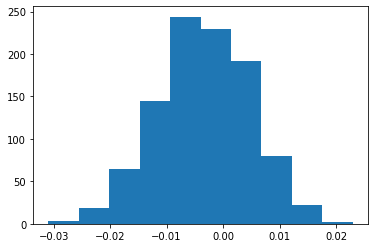

In [ ]:
#test = hk.without_apply_rng(hk.transform(lambda h0,o0 : my_module(hidden_size=5, number_layers=9, h0=h0, o0=o0, mlp_layers=[5,2,7]) ))

#params = test.init(rng=rng_key, h0=sample_x, o0=prev)
#g = test.apply(params, h0=sample_x, o0=prev)

################################################################################
mu1=-1
mu2=1
sigma1=0.5
sigma2=0.5
prop = 0.3
p = Distribution(mu1,mu2,sigma1,sigma2,prop=prop)

nbins = 4
key = rnd.PRNGKey(2)

test_model = Model(key, Module=LSTM_Module, hidden_size=10, n_particles=1, mlp_layers1=[3,5,3,3*nbins+1], mlp_layers2=[3,3,2], p=p)

#l, g = test_model.loss_and_grad(key, test_model.params, 10000)
#key, _ = rnd.split(key, 2)

plt.hist( test_model.q_theta(test_model.params)._sample_n(key, 1000).T )

## 1D learning

In [ ]:
################################################################################
# Distribution
mu1=-1
mu2=1
sigma1=0.5
sigma2=0.5
prop = 0.3
p = Distribution(mu1,mu2,sigma1,sigma2,prop=prop)

# Model
nbins = 3
key = rnd.PRNGKey(2)

model = Model(key, hidden_size=10, number_layers=1, mlp_layers=[3,5,3,3*nbins+1], p=p)
key, _ = rnd.split(key, 2)


# Learning
nsteps = 3000
lr = 1e-3
Ns = 10000
tx = optax.sgd(learning_rate=lr)
opt_state = tx.init(model.params)


L = np.zeros(nsteps)
for i in tqdm(range(nsteps)):
  L[i], g = model.loss_and_grad(key, model.params, Ns)
  key, _ = rnd.split(key, 2)


  if jnp.abs(L[i]) == np.infty or jnp.isnan(L[i]):
    print(g)
    break

  updates, opt_state = tx.update(g, opt_state)
  model.params = optax.apply_updates(model.params, updates)


  if i % 200 == 0:
    print(i, 'Loss = ', L[i])

  if i>0 and i%500==0 :
    plt.figure()
    plt.plot(range(i-500,i), L[i-500:i])
    plt.show()


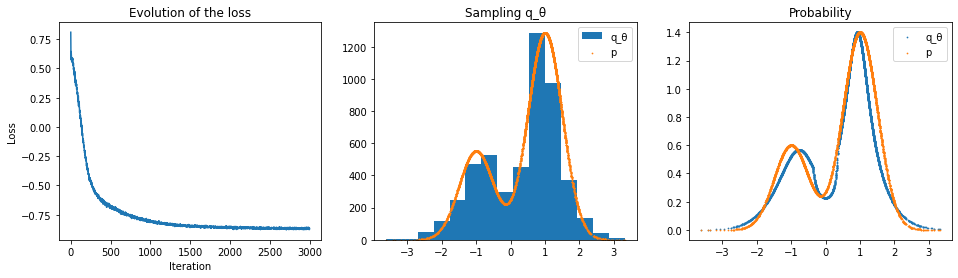

In [ ]:
plt.figure(figsize=(16,4))

################################################################################
plt.subplot(1,3,1)
plt.title('Evolution of the loss')
plt.plot(L)
plt.xlabel('Iteration')
plt.ylabel('Loss')



################################################################################
q = model.q_theta(params=model.params)    
x, logq = q._sample_n_and_log_prob(key, 5000)
key, _ = rnd.split(key, 2)
probs_p = jnp.exp( p.log_p(x) )
probs_q = jnp.exp( logq )


plt.subplot(1,3,2)
plt.title('Sampling q_θ')
hst = plt.hist(x.T, label='q_θ', zorder=0, bins=15)

qmax = jnp.max(hst[0])
C = qmax/jnp.max(probs_p)

plt.scatter(x, C*probs_p ,label='p', color='C1', zorder=1, s=0.5)
plt.legend()

################################################################################
A = jnp.max(probs_p)/np.exp( jnp.max(logq) )


plt.subplot(1,3,3)
plt.title('Probability')
plt.scatter(x, A*probs_q , label='q_θ', s=0.5)
plt.scatter(x, probs_p ,label='p', s=0.5)
plt.legend()

#plt.savefig('NN_3bins.png', dpi=200, bbox_inches='tight')
plt.show()

### Uncorrelated

In [ ]:
class UncorrelatedBiDimensionalDistribution:
  '''
  Creates a distribution which is an addition of two gaussians.
  The proportionality between the two is given by prop. 
  '''

  def __init__(self,mus,sigmas,coeffs):
    assert len(mus) == len(sigmas) & len(mus) == len(coeffs)
    self.mus = mus
    self.sigmas = sigmas

    self.coeffs=coeffs

  @partial(jit, static_argnums=0)
  def log_prob(self,x):
    '''
    unnormalized log probability of a sample
    does not need to be a nomralized probability
    x : samples (Ns, dimension=len(mus))

    Returns : log_p of the samples (Ns,)
    '''
    p = 0
    for i in range(len(self.mus)):
      p += self.coeffs[i]*jnp.exp(-(x-self.mus[i])**2/2/self.sigmas[i]) / self.sigmas[i]
    
    lp = jnp.sum( jnp.log( p ), axis=-1 )
    return lp



()


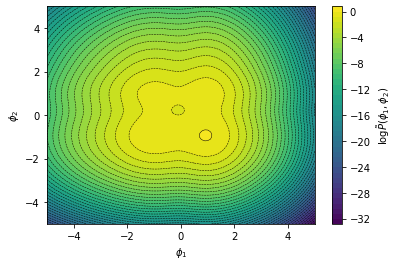

In [ ]:
mus = np.array([[1,1], [1,-1], [-1,1], [-1,-1]])
sigmas = np.array([0.3,1,0.5,0.5])
coeffs = np.array([0.1, 0.4, 0.3, 0.2])
distr = UncorrelatedBiDimensionalDistribution(mus, sigmas, coeffs)



# Verify gaussian shape
x = np.linspace(-5, 5, 101)



p = np.zeros( (101,101) )
for k in range(101):
    for j in range(101):
        p[k,j] = distr.log_p( np.array([x[k],x[j]]) )


fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.contourf(x, x, p, levels=50)
ax.contour(x, x, p, levels=50, colors='black', linewidths=.5)

#im = ax.scatter(phi1, phi2,c=p)
cbar = plt.colorbar(im)
cbar.set_label(r'$\log \tilde{P}(\phi_1, \phi_2)$')
ax.set_xlabel('$\phi_1$')
ax.set_ylabel('$\phi_2$')
plt.show()




In [ ]:

nbins = 4
key = rnd.PRNGKey(2)

test_model = Model(key, hidden_size=10, number_layers=2, mlp_layers=[3,5,3,3*nbins+1], p=distr)

l, g = test_model.loss_and_grad(key, test_model.params, 10000)
key, _ = rnd.split(key, 2)


(10000,)


### Correlated

In [ ]:
class CorrelatedBiDimensionalDistribution:
  '''
  Creates a distribution which is an addition of two gaussians.
  The proportionality between the two is given by prop. 
  '''

  def __init__(self,mus,Sigmas,coeffs):
    self.mus = mus

    # inverse of covariance matrix
    self.C = []
    self.norms = []
    for i in range(len(mus)):
      self.C.append( np.linalg.inv(Sigmas[i]) )
      self.norms.append( np.linalg.norm(self.C[i]) )

    self.coeffs=coeffs

  @partial(jit, static_argnums=0)
  def log_prob(self,data):
    '''
    unnormalized log probability of a sample
    does not need to be a nomralized probability
    data : samples (Ns, dimension=len(mus))

    Returns : log_p of the samples (Ns,)
    '''
    Ns = data.shape[0]

    p = np.zeros( (Ns,) )
    for i in range(len(self.mus)):

      arg = jnp.einsum('...j,jk,...k', (data-self.mus[i]), self.C[i], (data-self.mus[i]) )
      #print( (self.coeffs[i]*np.exp(-arg/2) /np.sqrt(self.norms[i])).shape )
      p += self.coeffs[i]*jnp.exp(-arg/2) /jnp.sqrt(self.norms[i])
    
    lp = jnp.log( p )
    return lp



In [ ]:
np.linalg.eigvals( np.array([[2,-1.2],[-1.2,1]]) )

array([2.8, 0.2])

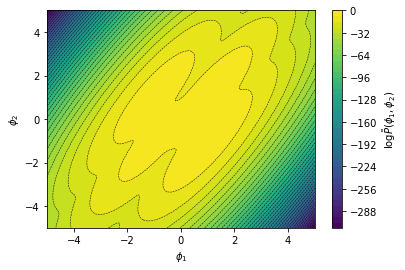

In [ ]:
#mus = [np.array([-1,-1]).T, np.array([1,1]).T]
#sigmas = [np.array([[0.5,0.15],[0.3,0.25]]), np.array([[0.5,0.3],[0.15,0.25]])]
#coeffs = np.array([0.1, 0.3])

mus = [np.array([-1,-1]).T, 
       np.array([-1,1]).T, 
       np.array([1,1]).T, 
       np.array([1,-1]).T
       ]
sigmas = [np.array([[0.5,0.3],[0.3,0.25]]), 
          np.array([[0.5,0.3],[0.3,0.25]]), 
          np.array([[0.5,0.3],[0.3,0.25]]), 
          np.array([[0.5,0.3],[0.3,0.25]])
          ]
coeffs = [0.05, 0.4, 0.4, 0.15]
distr = CorrelatedBiDimensionalDistribution(mus, sigmas, coeffs)



# Verify gaussian shape
x = np.linspace(-5, 5, 101)


p = np.zeros( (101,101) )
for k in range(101):
    for j in range(101):
        p[k,j] = distr.log_prob( np.array([[x[k],x[j]]]) )


fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.contourf(x, x, p, levels=50)
ax.contour(x, x, p, levels=50, colors='black', linewidths=.5)


cbar = plt.colorbar(im)
cbar.set_label(r'$\log \tilde{P}(\phi_1, \phi_2)$')
ax.set_xlabel('$\phi_1$')
ax.set_ylabel('$\phi_2$')
plt.show()




In [ ]:
mus = [np.tile([-1,-1], (10000,1)), np.tile([1,1], (10000,1))]

sigmas = [np.array([[0.5,0.15],[0.3,0.25]]), np.array([[0.5,0.3],[0.15,0.25]])]
coeffs = [0.1, 0.3]
distr = CorrelatedBiDimensionalDistribution(mus, sigmas, coeffs)


nbins = 4
key = rnd.PRNGKey(2)

test_model = Model(key, hidden_size=10, number_layers=2, mlp_layers=[3,5,3,3*nbins+1], p=distr)

l, g = test_model.loss_and_grad(key, test_model.params, 10000)
key, _ = rnd.split(key, 2)


### Ising

In [4]:
def generate_H(N, beta, h, dim=1):
  '''
  Generates the external field matrix H
  
  N : number of particles
  beta : inverse temperature of the system
  h : amplitude of the field
  dim : numer of dimensions (default 1)

  returns : H matrix (N,)
  '''
  assert dim==1 or dim==2 or dim==3

  return beta*h*np.ones( N**dim )

def generate_NN(N, beta, jnn, dim=1, pbc=True):
  '''
  Generates the interaction matrices (mulriplied by beta) for the second neighbours model

  N : number of particles
  beta : inverse temperature of the system
  jnn : amplitude of the first neighbour interaction
  dim : numer of dimensions (default 1)
  pbc : if the system presents periodic boundary conditions (default True)

  returns : modified interaction matrix K (N,N) and normal one J (N,N)
  '''
  assert dim==1 or dim==2 or dim==3

  # Nearest neighbours matrix
  NN = np.diag(np.ones(N-1), 1) + np.diag(np.ones(N-1), -1)

  # Boundary conditions
  if pbc : 
    NN[0,N-1] = 1
    NN[N-1,0] = 1
  NN *= jnn

  # Construct nearest neighbour for each lattice
  if dim == 1 : 
    '''
    Nearest neighbours in (+/-a)
    '''
    J = NN
  if dim == 2:
    '''
    Nearest neighbours in (+/-a,0), (0,+/-a)
    '''
    I = np.diag( np.ones(N) )
    J = np.kron(I,NN) + np.kron(NN,I)
  if dim == 3:
    '''
    Nearest neighbours in (+/- a,0,0), (0,+/- a,0), (0,0,+/- a)
    '''
    I = np.diag( np.ones(N) )
    J = np.kron(np.kron(I, NN), I) + np.kron(np.kron(NN, I), I) + np.kron(I, np.kron(I,NN))

  # Construct J and K
  J = beta*J
  K = J + 2.5*dim*beta*np.abs(jnn)*np.diag(np.ones(N**dim))
  return K,J

def generate_NNN(N, beta, jnn, jnnn, dim=1, pbc=True):
  '''
  Generates the interaction matrices (mulriplied by beta) for the second neighbours model

  N : number of particles
  beta : inverse temperature of the system
  jnn : amplitude of the first neighbour interaction
  jnnn : amplitude of the second neighbour interaction
  dim : numer of dimensions (default 1)
  pbc : if the system presents periodic boundary conditions (default True)

  returns : modified interaction matrix K (N,N) & standard one J (N,N)
  '''
  assert dim==1 or dim==2 or dim==3

  # Nearest neighbours
  T = np.diag(np.ones(N-1), 1) + np.diag(np.ones(N-1), -1)

  # Boundary conditions
  if pbc : 
    T[0,N-1] = 1
    T[N-1,0] = 1

  if dim == 1 : 
    '''
    Nearest neighbours in (+/-a)
    Second neighbours in (+/-2a)
    '''
    NNN = np.diag(np.ones(N-2), 2) + np.diag(np.ones(N-2), -2)
    if pbc : 
        NNN[0,N-2] = 1
        NNN[N-2,0] = 1
    J = jnn*T + jnnn*NNN
  if dim == 2:
    '''
    Nearest neighbours in (+/-a,0), (0,+/-a)
    Second neighbours in (+/-a,+/-a)
    '''
    I = np.diag( np.ones(N) )
    J = jnn*np.kron(I,T) + jnn*np.kron(T,I) + jnnn*np.kron(T,T)
  if dim == 3:
    '''
    Nearest neighbours in (+/- a,0,0), (0,+/- a,0), (0,0,+/- a)
    Second neighbours in (+/-a,+/-a,0), (+/-a,0,+/-a), (0,+/-a,+/-a)
    '''
    I = np.diag( np.ones(N) )
    J = jnn*( np.kron(np.kron(I, T), I) + np.kron(np.kron(T, I), I) + np.kron(I, np.kron(I,T)) )
    J += jnnn*( np.kron(np.kron(T, I), T) + np.kron(np.kron(I, T), T) + np.kron(T, np.kron(T,I)) )

  # Construct J and K
  if jnnn ==0:
    diag = 2.5*dim*beta*np.abs(jnn)
  else : 
    diag = 6*dim*beta*max(np.abs(jnn),np.abs(jnnn))

  J = beta*J
  K = J +diag*np.diag(np.ones(N**dim))
  return K,J

In [5]:
class IsingDistribution:
  '''
  Probability distribution of the ising model for a given interaction matrix and external field
  H = - 0.5 * sum_ij s_i J_ij s_j - sum_i h_i s_i

  hint : j=1 is ferromagnetic
  '''
  def __init__(self, N, J, K, H, beta=None):
    '''
    Initialises the model for the given interactions and fields. 

    N : number of particles (int)
    J : NxN array defining the interactions (multiplied by beta already)
    K : J with addititonal diagonal terms to be positive definite
    H : external field (multiplied by beta)
    '''
    # Verifying the shapes of the matrices
    assert J.shape[0] == N and J.shape[1] == N and J.shape == K.shape

    # Verifying that K is indeed positive definite
    assert (np.linalg.eigvalsh(K) > 0).all()

    self.N = N
    self.J = J
    self.K = K
    self.H = H
    self.beta = beta

  def log_prob(self,phis):
    '''
    Log of the unnormalized probability distribution in continuous space
    phi : ambiant field for which one computes the prob, shape (Ns,n_part)

    return : log(p(phi)), shape (Ns,)
    '''
    # Exponential part
    p = -0.5*jnp.einsum('...j,jk,...k', phis, self.K, phis )
    
    # Product of i part (separating the log for stability)
    x = jnp.einsum('jk,...k', self.K, phis ) + self.H
    p += jnp.sum( jnp.abs(x) + jnp.log1p(jnp.exp(-2*jnp.abs(x))) , axis=-1 )
      
    return p

  def discrete_log_prob(self,spins):
    '''
    Probability in the spin space
    spins : spin samples (Ns,n_part)

    return : log(p(s)) = -beta*E(s), shape (SHAPE)
    '''
    return 0.5*jnp.einsum('ji,ik,jk->j', spins, self.J, spins) + jnp.einsum('k,jk->j', self.H,spins)
    return 0.5*spins.T @ self.J @ spins + self.H@spins

  def componentwise_magn(self,data): #OK
    '''
    Coputes the magnetization of each component for a bunch of data
    data : data sampled over whcich to average (Ns,N)

    returns : magnetization (N,)
    '''
    g = jnp.tanh( jnp.einsum('jk,...k', self.K, data ) + self.H )

    return jnp.mean(g, axis=0)

  def mean_magn(self,data): #OK
    '''
    Computes the mean magnetization over all components
    data : data sampled over whcich to average (Ns,N)

    returns : mean magnetization ()
    '''
    g = jnp.tanh( jnp.einsum('jk,...k', self.K, data ) + self.H ).mean(axis=-1)

    return jnp.mean(g, axis=0)


  def correlations(self,data, i=0):
    '''
    Computes the correlations between the spin i and the other spins (also itself)
    data : data sampled over whcich to average (Ns,N)
    i : component w.r.t. which to compute the correlations

    returns : array of correlations (N,)
    '''
    m = jnp.tanh( jnp.einsum('jk,nk->nj', self.K, data ) + self.H )

    g = m[i] * m # IS THERE A - MISSING ???

    g = g.at[:,i].set(1.0)

    return jnp.mean(g, axis=0)

  def magnetic_suscpetibility(self,data):
    '''
    Computes the magnetic susceptibility of the lattice
    data : data sampled over whcich to average (Ns,N)

    returns : magnetic susceptibility ()
    '''
    m = jnp.tanh( jnp.einsum('jk,nk->nj', self.K, data ) + self.H )

    energys = self.beta**2/self.N**2 * jnp.sum( jnp.einsum('ji,jk->jik', m, m), axis=(-1,-2) )
    return jnp.mean(energys, axis=0)

  def energy(self,data):
    '''
    Computes the energy of the lattice
    data : data sampled over whcich to average (Ns,N)

    returns : energy ()
    '''
    x = jnp.einsum('jk,nk->nj', self.K, data ) + self.H
    

    E_loc = (0.5*jnp.einsum('nj,jk,nk->n', data, self.K, data ) - jnp.einsum('ni,ni->n', x, jnp.tanh(x)) )/self.beta

    return jnp.mean(E_loc, axis=0) + jnp.einsum('ii', self.K)



## 2D Learning

In [ ]:
################################################################################
# Distribution
'''
mus=np.array([1, -1])
sigmas = np.array([0.5, 0.5])
coeffs = np.array([0.7, 0.3])
p = UncorrelatedBiDimensionalDistribution(mus, sigmas, coeffs)
n_particles = 1
'''
'''
mus = np.array([[1,1], [1,-1], [-1,1], [-1,-1]])
sigmas = np.array([0.3,1,0.5,0.5])
coeffs = np.array([0.1, 0.4, 0.3, 0.2])
p = UncorrelatedBiDimensionalDistribution(mus, sigmas, coeffs)
n_particles = 2
'''
'''
mus = [np.array([1,1])]
sigmas = [np.array([[1,0.6],[0.6,0.5]])]
#sigmas = [np.array([[1,0],[0,0.5]])]
coeffs = [1]
p = CorrelatedBiDimensionalDistribution(mus, sigmas, coeffs)
n_particles = 2
'''

mus = [np.array([-1,-1]).T, 
       np.array([-1,1]).T, 
       np.array([1,1]).T, 
       np.array([1,-1]).T
       ]
sigmas = [np.array([[0.5,0.3],[0.3,0.25]]), 
          np.array([[0.5,0.3],[0.3,0.25]]), 
          np.array([[0.5,0.3],[0.3,0.25]]), 
          np.array([[0.5,0.3],[0.3,0.25]])
          ]
coeffs = [0.05, 0.4, 0.4, 0.15]
p = CorrelatedBiDimensionalDistribution(mus, sigmas, coeffs)
n_particles = 2




# Model
nbins = 3
key = rnd.PRNGKey(12)


model = Model(key, Module=LSTM_Module, hidden_size=10, n_particles=n_particles, mlp_layers1=[3,5,3*nbins+1], p=p)
key, _ = rnd.split(key, 2)



# Learning
nsteps = 10000
lr = 5e-3
Ns = 20000
tx = optax.sgd(learning_rate=lr)
opt_state = tx.init(model.params)


L = np.zeros(nsteps)
means = []
covs = []

for i in tqdm(range(nsteps)):
  L[i], g = model.loss_and_grad(key, model.params, Ns)
  key, _ = rnd.split(key, 2)


  if jnp.abs(L[i]) == np.infty or jnp.isnan(L[i]):
    print(g)
    break

  updates, opt_state = tx.update(g, opt_state)
  model.params = optax.apply_updates(model.params, updates)

  # Keep track of evolution
  if i % 200 == 0:
    print(i, 'Loss = ', L[i])
  
  # See loss
  if i>0 and i%500==0 :
    plt.figure()
    plt.plot(range(i-500, i), L[i-500:i])
    plt.show()
  
  # See distribution
  if (i+1)%500 == 0:
    
    size = 21
    x = np.linspace(-3, 3, size)
    probs_q = np.zeros( (size,size) )
    for k in range(size):
      for j in range(size):
        probs_q[k,j] = model.log_prob( model.params, np.array([[x[k], x[j]]]) )

    plt.contourf(x, x, np.exp(probs_q), levels=20)
    plt.contour(x, x, np.exp(probs_q), colors='black', levels=20, linewidths=.5, linestyles='solid')
    plt.show() 
    
    #_, data = model.sample_and_log_q(key, model.params, Ns=10000)
    #means.append( np.mean(data, axis=0) )
    #covs.append( np.cov(data.T) )
    #print(i, 'Distribution : ', means[-1], covs[-1])
    

In [ ]:
arr_means = np.array(means)
arr_covs = np.array(covs)


plt.figure(figsize=(20,4))

################################################################################
plt.subplot(1,4,1)
plt.title('Evolution of the loss')
plt.plot(L[L!=0], label='L')
#plt.hlines(y=-5.3288, xmin=0, xmax=i, color='k', linestyle='dashed')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()



################################################################################
q = model.q_theta(params=model.params)    
data = q._sample_n(key, 10000)
key, _ = rnd.split(key, 2)

size = 21
H, yedges, xedges = np.histogram2d(data[:,0], 
                                   data[:,1], 
                                   bins=[np.linspace(-2,2,size),np.linspace(-2,2,size)]
                                   )
X, Y = np.meshgrid(xedges, yedges)

plt.subplot(1,4,2)
plt.title('Sampling q_θ')

plt.pcolormesh(X, Y, H)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')


################################################################################

size = 21
x = np.linspace(-2.5, 2.5, size)
probs_p = np.zeros( (size,size) )
probs_q = np.zeros( (size,size) )
for k in range(size):
    for j in range(size):
        probs_p[k,j] = model.p.log_prob( np.array( [[x[k],x[j]]] ) )
        probs_q[k,j] = model.log_prob( model.params, np.array([[x[k],x[j]]]) )



plt.subplot(1,4,3)
plt.title('p to learn')

plt.contourf(x, x, np.exp(probs_p), levels=10)
plt.contour(x, x, np.exp(probs_p), colors='black', levels=10, linewidths=.5, linestyles='solid')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')


################################################################################

plt.subplot(1,4,4)
plt.title('q_θ learned')

plt.contourf(x, x, np.exp(probs_q), levels=10)
plt.contour(x, x, np.exp(probs_q), colors='black', levels=10, linewidths=.5, linestyles='solid')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')


#plt.savefig(f'{Module}.png', dpi=200, bbox_inches='tight')

################################################################################

plt.show()


# Real Recurrent model

## Model

In [ ]:
##################################### LSTM #####################################
class Recurrent_Module(hk.Module):
  def __init__(self, hidden_size, number_layers, mlp_layers1, mlp_layers2, name='LSTM_module'):
    '''
    hidden_size : size of each input/output
    number_layers : number of times the RNN is called (corresponds to the number of particles)
    mlp_layers : the layers of the MLP
    '''
    super().__init__(name=name)
    self.rnn = hk.LSTM(hidden_size=hidden_size) #shared weights

    self.number_layers = number_layers
    
    self.mlp1 = hk.nets.MLP(
        mlp_layers1,
        activation = jax.nn.tanh, 
        w_init = hk.initializers.VarianceScaling(1.0, "fan_in",  "truncated_normal"), #hk.initializers.RandomNormal(1,0),
        b_init = hk.initializers.Constant(0), 
        name = 'MLP1'
        )
    self.mlp2 = hk.nets.MLP(
        mlp_layers2,
        activation = jax.nn.tanh, 
        w_init = hk.initializers.VarianceScaling(1.0, "fan_in",  "truncated_normal"), #hk.initializers.RandomNormal(1,0),
        b_init = hk.initializers.Constant(0), 
        name = 'MLP2'
        )

  def __call__(self,inputs, previous_state=None):
    '''
    Returns a list of outputs o in the RNN chain
    inputs : intial entry of the RNN (o0), shape : (Ns, hidden_size)
    previous_state : previous state of the netowrk [hidden: (hidden,Ns), cell: (hidden,Ns)]

    return : outputs (number_layers, Ns, mlp_layers[-1]) & [hidden: (hidden,Ns), cell: (hidden,Ns)]
    '''
    # Prepare states
    if previous_state is None:
      previous_state = self.rnn.initial_state(inputs.shape[0])

    o, previous_state = self.rnn(inputs, previous_state)

    # return outputs and the final states (to go on if needed)
    return self.mlp1(o), self.mlp2(o), previous_state

    
def recurrent_module_fn(Module, hidden_size, number_layers, mlp_layers1, mlp_layers2, inputs, previous_state):
  '''
  Forwards the RNN + MLP network

  Module : module to use for the RNN (can be Vanilla_MLP_Module or LSTM_MLP_Module)
  hidden_size : size of each input/output
  number_layers : number of times the RNN is called (corresponds to the number of particles)
  mlp_layers : the layers of the MLP
  inputs : intial entry of the RNN (o0), shape : (Ns, hidden_size)
  '''
  module = Module(hidden_size, number_layers, mlp_layers1, mlp_layers2)
  return module(inputs, previous_state)

class Recurrent_Model:
  '''
  Defines the Autoregressive flows model used.
  Each RNN cell (all with same parameters) gives an output (input of the next cell)
  which passes in a MLP (with shared weights again) to define the paramters of the RQS
  '''
  def __init__(self, key, Module, hidden_size, n_particles, mlp_layers1, mlp_layers2, p):
    '''
    key : random key to intialize the parameters
    hidden_size : size of the hidden vectors & outputs
    n_particles : number of outputs / variables = number of particles
    mlp_layers1 : layers of the MLP block for the spline (last layer MUST be 3*nbins+1)
    mlp_layers2 : layers of the MLP block for the shift
    p : distribution to learn (must have a log_prob) 
    '''
    assert mlp_layers1[-1] % 3 == 1
    assert mlp_layers2[-1] == 1

    # The neural network (RNN -> MLP1,MLP2)
    self.NN = hk.without_apply_rng(hk.transform(lambda inputs, previous_state : recurrent_module_fn(
        Module = Module,
        hidden_size = hidden_size, 
        number_layers = n_particles, 
        mlp_layers1 = mlp_layers1, 
        mlp_layers2 = mlp_layers2,
        inputs = inputs, 
        previous_state = previous_state
    ) ))
    
    # Initialize the corresponding parameters
    self.params = self.NN.init(rng=key, inputs=np.zeros(shape=(1,1) ), previous_state=None)
    key, _ = rnd.split(key, 2)

    # Probability to learn
    self.p = p

    # Number of particles (components)
    self.n_particles = n_particles


  @partial(jit, static_argnums = (0,3))
  def sample_and_log_q(self, key, params, Ns):
    '''
    Draws samples from the distribution defined by params

    key : random key to sample
    params : parameters of the distribution q_theta
    Ns : number of samples

    returns : log_probabilities of each sample chain (Ns,) & samples (Ns,n_particles)
    '''
    # To contain the important information
    log_probs = jnp.zeros(shape=(Ns,))
    phi = []

    ## t = 0 (special since here we sample Ns times from the same spline)
    o = np.zeros(shape=(1,Ns))
    previous_state = None
    g1, g2, previous_state = self.NN.apply( params, inputs=o.T, previous_state=previous_state ) #shapes (Ns,mlp[-1])
    
    # Distribution of phi0
    bij = distrax.Chain([ 
                        distrax.ScalarAffine( shift = g2[:,0], scale=np.ones(shape=(Ns,)) ) ,
                        distrax.Inverse( distrax.Tanh() ), 
                        distrax.RationalQuadraticSpline(g1, -1.0, 1.0),
                        distrax.Tanh(),
                      ])
    
    q = distrax.Transformed( distrax.Normal(np.zeros(Ns),np.ones(Ns)), 
                              bij
                              )
    
    # sample, save and input for the next one 
    o, log_p = q._sample_n_and_log_prob(key, 1)
    key, _ = rnd.split(key, 2)
    log_probs += jnp.squeeze(log_p, axis=0)
    phi.append( o )
    

    ## for t>0, we sample one time for each of the Ns distributions created (different splines)
    for t in range(1,self.n_particles):
      g1, g2, previous_state = self.NN.apply( params, inputs=o.T, previous_state=previous_state ) #shapes (Ns,mlp[-1])


      # Chain([f,g]) -> f(g(x))
      bij = distrax.Chain([ 
                          distrax.ScalarAffine( shift = g2, scale=np.ones(shape=(Ns,1,)) ) ,
                          distrax.Inverse( distrax.Tanh() ), 
                          distrax.RationalQuadraticSpline(jnp.expand_dims(g1, axis=1), -1.0, 1.0), #expand_dims to have Ns different splines
                          distrax.Tanh(),
                        ])
      

      q = distrax.Transformed( distrax.Normal(loc=jnp.zeros((Ns,1)), scale=jnp.ones((Ns,1))), # to have Ns samples drawn independently
                              bij
                              )
      
      o, log_p = q._sample_n_and_log_prob(key, 1)
      key, _ = rnd.split(key, 2)

      # cancel the additional dim
      o = jnp.squeeze(o, axis=-1)
      log_probs += jnp.squeeze(log_p, axis=(0,-1))
      phi.append( o )

    # Transform to the shape we wished (Ns,n_parts)
    data = jnp.squeeze( jnp.array(phi), axis=1).T


    return log_probs, data


  @partial(jit, static_argnums = (0,3))
  def loss(self, key, params, Ns):
    '''
    Constructs the pseudo loss which needs to be differentiated for the gradient
    params : parameters of the distribution
    data : samples from q_theta to compute the expectation value (NS, n_particles)

    Returns : loss () # & pseudo loss to differentiate ()
    '''
    logq, data = self.sample_and_log_q(key, params, Ns) #(Ns, n_particles) & (Ns,)


    logp = self.p.log_prob(data) #(Ns,)
    #l = jnp.mean( logq * (0.5*logq - logp), axis=0 )

    return jnp.mean(logq-logp, axis=0)

  @partial(jit, static_argnums = (0,3))
  def loss_and_grad(self, key, params, Ns):
    '''
    Computes the loss and its gradient
    key : random key to sample
    params : parameters of the distribution q_theta
    Ns : number of samples

    Returns : loss () and gradient of the loss (params-like)
    '''
    value, grad_L = jax.value_and_grad(self.loss, argnums=1, has_aux=False)(key, params, Ns)


    return value, grad_L
    


  @partial(jit, static_argnums=0)
  def log_prob(self, params, x):
    '''
    x : (Ns, n_part)
    return : lob_p (Ns,)
    '''
    if x.ndim == 1:
      x = jnp.expand_dims(x, axis=0)
      Ns = 1
    else: 
      Ns = x.shape[0]
    #assert x.ndim != 1
    #Ns = x.shape[0]

    ## t = 0 (special since here we sample Ns times from the same spline)
    o = np.zeros(shape=(1,Ns))
    previous_state = None
    g1, g2, previous_state = self.NN.apply( params, inputs=o.T, previous_state=previous_state ) #shapes (1,mlp[-1])
    bij = distrax.Chain([ 
                        distrax.ScalarAffine( shift = g2[:,0], scale=np.ones(shape=(1,)) ),
                        distrax.Inverse( distrax.Tanh() ), 
                        distrax.RationalQuadraticSpline(g1, -1.0, 1.0), #expand nums to have Ns different splines
                        distrax.Tanh(),
                      ])
    q = distrax.Transformed( distrax.Normal(np.zeros(Ns),np.ones(Ns)), 
                              bij 
                              )
    
    probs = jnp.squeeze( q.log_prob(x[...,0]), axis=0)

    

    ## for t>0, we sample one time for each of the Ns distributions created (different splines)
    for t in range(1,self.n_particles): 

      g1, g2, previous_state = self.NN.apply( params, inputs=jnp.expand_dims(x[...,t-1].T, axis=1), previous_state=previous_state ) #shapes (Ns,mlp[-1])


      # Chain([f,g]) -> f(g(x))
      bij = distrax.Chain([ 
                          distrax.ScalarAffine( shift = g2, scale=np.ones(shape=(Ns,1,)) ),
                          distrax.Inverse( distrax.Tanh() ), 
                          distrax.RationalQuadraticSpline(jnp.expand_dims(g1, axis=1), -1.0, 1.0), #expand nums to have Ns different splines
                          distrax.Tanh(),
                        ])
      q = distrax.Transformed( distrax.Normal(loc=jnp.zeros((Ns,1)), scale=jnp.ones((Ns,1))), # to have Ns samples drawn independently
                              bij 
                              )
      
      probs += jnp.squeeze( q.log_prob(x[...,t]), axis=(0,-1))


    return probs

## Learn

In [6]:
################################################################################
# Distribution
n_particles = 10
d = 1
pbc = True

beta = 1
h = 1
jnn = -1
jnnn = 0

H = generate_H(n_particles, beta, h, d)
K, J = generate_NNN(n_particles, beta, jnn, jnnn, d, pbc)
p = IsingDistribution(n_particles,J,K,H,beta)

'''
size = 51
x = np.linspace(-4, 4, size)
probs_p = np.zeros( (size,size) )
for k in range(size):
    for j in range(size):
        probs_p[k,j] = p.log_prob( np.array( [[x[k],x[j]]] ) )


plt.title('p to learn')

plt.contourf(x, x, np.exp(probs_p), levels=10)
plt.contour(x, x, np.exp(probs_p), colors='black', levels=10, linewidths=.5, linestyles='solid')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

print( np.trapz(np.trapz(np.exp(probs_p), x=x), x=x) )
'''

"\nsize = 51\nx = np.linspace(-4, 4, size)\nprobs_p = np.zeros( (size,size) )\nfor k in range(size):\n    for j in range(size):\n        probs_p[k,j] = p.log_prob( np.array( [[x[k],x[j]]] ) )\n\n\nplt.title('p to learn')\n\nplt.contourf(x, x, np.exp(probs_p), levels=10)\nplt.contour(x, x, np.exp(probs_p), colors='black', levels=10, linewidths=.5, linestyles='solid')\n\nplt.xlabel('$x_1$')\nplt.ylabel('$x_2$')\n\nprint( np.trapz(np.trapz(np.exp(probs_p), x=x), x=x) )\n"

In [ ]:
L_temp = L
L = np.zeros(60000)
L[:nsteps] = L_temp

  0%|          | 0/10000 [00:00<?, ?it/s]

0 Loss =  -27.01534726465269
200 Loss =  -28.082682543090126
400 Loss =  -28.213305663343473


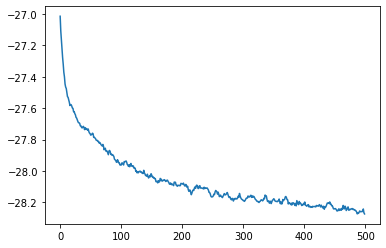

600 Loss =  -28.322909323513272
800 Loss =  -28.416545580822685
1000 Loss =  -28.54860714815032


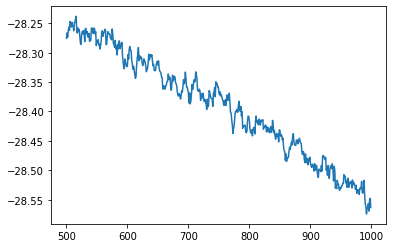

1200 Loss =  -28.70726131121103
1400 Loss =  -28.83639879870657


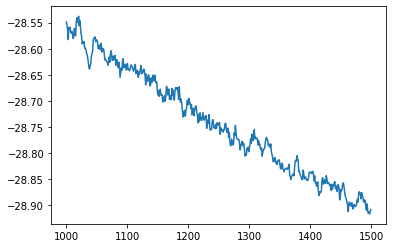

1600 Loss =  -28.9678307118525
1800 Loss =  -29.089623196593312
2000 Loss =  -29.22119597620525


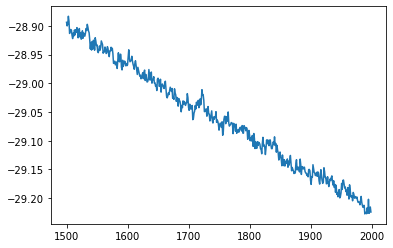

2200 Loss =  -29.35013105811982
2400 Loss =  -29.433313375394963


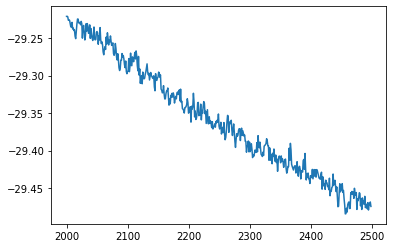

2600 Loss =  -29.499358313364805
2800 Loss =  -29.572830367913593
3000 Loss =  -29.6169055987763


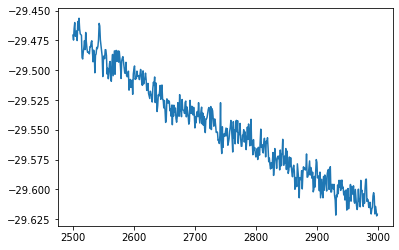

3200 Loss =  -29.653612939305162


KeyboardInterrupt: ignored

In [7]:
################################################################################
# Distribution
'''
mus=np.array([1, -1])
sigmas = np.array([0.5, 0.5])
coeffs = np.array([0.7, 0.3])
p = UncorrelatedBiDimensionalDistribution(mus, sigmas, coeffs)
n_particles = 1
'''
'''
mus = np.array([[1,1], [1,-1], [-1,1], [-1,-1]])
sigmas = np.array([0.3,1,0.5,0.5])
coeffs = np.array([0.1, 0.4, 0.3, 0.2])
p = UncorrelatedBiDimensionalDistribution(mus, sigmas, coeffs)
n_particles = 2
'''
'''
mus = [np.array([1,1])]
sigmas = [np.array([[1,0.6],[0.6,0.5]])]
#sigmas = [np.array([[1,0],[0,0.5]])]
coeffs = [1]
p = CorrelatedBiDimensionalDistribution(mus, sigmas, coeffs)
n_particles = 2
'''
'''
mus = [np.array([-1,-1]).T, 
       np.array([-1,1]).T, 
       np.array([1,1]).T, 
       np.array([1,-1]).T
       ]
sigmas = [np.array([[0.5,0.3],[0.3,0.25]]), 
          np.array([[0.5,0.3],[0.3,0.25]]), 
          np.array([[0.5,0.3],[0.3,0.25]]), 
          np.array([[0.5,0.3],[0.3,0.25]])
          ]
coeffs = [0.05, 0.4, 0.4, 0.15]
p = CorrelatedBiDimensionalDistribution(mus, sigmas, coeffs)
n_particles = 2
'''



# Model
nbins = 3
key = rnd.PRNGKey(12)


model = Recurrent_Model(key, Module=Recurrent_Module, hidden_size=10, n_particles=n_particles, mlp_layers1=[5,3*nbins+1], mlp_layers2=[6,4,1], p=p)
key, _ = rnd.split(key, 2)



# Learning
nsteps = 10000
lr = 5e-3
Ns = 20000
tx = optax.sgd(learning_rate=lr)
opt_state = tx.init(model.params)


L = np.zeros(nsteps)
means = []
covs = []

for i in tqdm(range(nsteps)):
  L[i], g = model.loss_and_grad(key, model.params, Ns)
  key, _ = rnd.split(key, 2)


  if jnp.abs(L[i]) == np.infty or jnp.isnan(L[i]):
    print(g)
    break

  updates, opt_state = tx.update(g, opt_state)
  model.params = optax.apply_updates(model.params, updates)

  # Keep track of evolution
  if i % 200 == 0:
    print(i, 'Loss = ', L[i])
  
  # See loss
  if i>0 and i%500==0 :
    plt.figure()
    plt.plot(range(i-500, i), L[i-500:i])
    plt.show()
    
  '''
  # See distribution
  if (i+1)%500 == 0:
    
    size = 21
    x = np.linspace(-3, 3, size)
    probs_q = np.zeros( (size,size) )
    for k in range(size):
      for j in range(size):
        probs_q[k,j] = model.log_prob( model.params, np.array([[x[k], x[j]]]) )

    plt.contourf(x, x, np.exp(probs_q), levels=20)
    plt.contour(x, x, np.exp(probs_q), colors='black', levels=20, linewidths=.5, linestyles='solid')
    plt.show() 
    
    #_, data = model.sample_and_log_q(key, model.params, Ns=10000)
    #means.append( np.mean(data, axis=0) )
    #covs.append( np.cov(data.T) )
    #print(i, 'Distribution : ', means[-1], covs[-1])
    '''

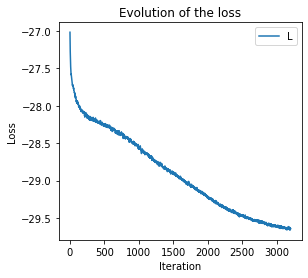

In [8]:
arr_means = np.array(means)
arr_covs = np.array(covs)


plt.figure(figsize=(20,4))

################################################################################
plt.subplot(1,4,1)
plt.title('Evolution of the loss')
plt.plot(L[L!=0], label='L')
#plt.hlines(y=-5.3288, xmin=0, xmax=i, color='k', linestyle='dashed')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()


'''
################################################################################
probs, data = model.sample_and_log_q(key, model.params, Ns=10000)
#q = model.q_theta(params=model.params)    
#data = q._sample_n(key, 10000)
#key, _ = rnd.split(key, 2)
size = 21
H, yedges, xedges = np.histogram2d(data[:,0], 
                                   data[:,1], 
                                   bins=[np.linspace(-2,2,size),np.linspace(-2,2,size)]
                                   )
X, Y = np.meshgrid(xedges, yedges)

plt.subplot(1,4,2)
plt.title('Sampling q_θ')

plt.pcolormesh(X, Y, H)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')


################################################################################

size = 21
x = np.linspace(-2.5, 2.5, size)
probs_p = np.zeros( (size,size) )
probs_q = np.zeros( (size,size) )
for k in range(size):
    for j in range(size):
        probs_p[k,j] = model.p.log_prob( np.array( [[x[k],x[j]]] ) )
        probs_q[k,j] = model.log_prob( model.params, np.array([[x[k],x[j]]]) )



plt.subplot(1,4,3)
plt.title('p to learn')

plt.contourf(x, x, np.exp(probs_p), levels=10)
plt.contour(x, x, np.exp(probs_p), colors='black', levels=10, linewidths=.5, linestyles='solid')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')


################################################################################

plt.subplot(1,4,4)
plt.title('q_θ learned')

plt.contourf(x, x, np.exp(probs_q), levels=10)
plt.contour(x, x, np.exp(probs_q), colors='black', levels=10, linewidths=.5, linestyles='solid')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')


plt.savefig(f'Ising_jnn={jnn}_h={h}.png', dpi=200, bbox_inches='tight')
################################################################################
################################################################################
'''
plt.show()


In [11]:
# To import/export parameters 
import pickle

path = f'Loss_N={n_particles}_jnn={jnn}_jnnn={jnnn}_h={h}.pickle'
with open(path, 'wb') as file:
    pickle.dump(L[L!=0], file)

path = f'Parameters_N={n_particles}_jnn={jnn}_jnnn={jnnn}_h={h}.pickle'
with open(path, 'wb') as file:
    pickle.dump(model.params, file)

path = f'HyperParams_N={n_particles}_jnn={jnn}_jnnn={jnnn}_h={h}.txt'
sample = open(path, 'w')
print(f'hidden_size : {10}', file=sample)
print(f'mlp_layers1 : {[5,10]}', file=sample)
print(f'mlp_layers2 : {[6,4,1]}', file=sample)
print(f'p : h={h}, jnn={jnn}, jnnn={jnnn}, beta={beta}, pbc={pbc}', file=sample)
sample.close()

'''
with open(path, 'rb') as file:
    data = pickle.load(file)
'''

"\nwith open(path, 'rb') as file:\n    data = pickle.load(file)\n"

In [ ]:
'''
Attempt at doing the gradient by hand, does not work yet
'''

#!pip install tree-math
#import tree_math as tm
logq, data= model.sample_and_log_q(key, model.params, 50)
#dlogq = jax.vmap(grad(model.log_prob), in_axes=(None,0), out_axes=0)(model.params,data)
logp = model.p.log_prob(data)


x = data[0]
dlogq = grad(model.log_prob, argnums=0)(model.params,x)


#print(dlogq)
#v = tm.Vector(dlogq)
#print(v.shape)
#print(logp.shape, logq.shape, v.shape)
#v = v*(logq[0]-logp[0])
#print(v.shape)

def local_grad(x):
  print('x is ', x.shape)
  logq, dlogq = jax.value_and_grad(model.log_prob, argnums=0)(model.params,x)
  logp = model.p.log_prob(jnp.array([x]))[0]
  print('lp ', logp.shape, logq.shape)

  v = tm.Vector(dlogq)
  v = v*(logq - logp)
  print(v.shape)
  return v

g = vmap(local_grad, in_axes=0, out_axes=0)(data)
g.shape



x is  (2,)
lp  () ()
(689,)


(34450,)